In [19]:
import numpy as np
from cleanrl.ppo_continuous_action import Agent
from envs.shell import shell
from cleanrl.ppo_continuous_action import make_env
import gymnasium as gym
import torch
import matplotlib.pyplot as plt 

In [20]:
envs_eval = gym.vector.SyncVectorEnv(
    [make_env(1, i, False, 1, 0.99) for i in range(10)])

q = envs_eval.envs[0].q
r = envs_eval.envs[0].r

In [21]:
y = [] 
du = [] 

envs_eval = gym.vector.SyncVectorEnv(
    [make_env(1, i, False, 1, 0.99) for i in range(10)])
agent = Agent(envs_eval)
agent.load_state_dict(torch.load('./models/HalfCheetah-v4__ppo_continuous_action__1234__1687702659/best_agent.pt'))

next_obs_eval, _ = envs_eval.reset() 
returns_eval = [] 
while len(returns_eval) < 10:
    while True:
        y.append(np.array([envs_eval.envs[i].y for i in range(10)]).squeeze())
        du.append(np.array([envs_eval.envs[i].du for i in range(10)]).squeeze())
        
        with torch.no_grad():
            # mean = np.array([envs_eval.envs[i].obs_rms.mean for i in range(10)])
            # var = np.array([envs_eval.envs[i].obs_rms.var for i in range(10)])
            # next_obs_eval = next_obs_eval * np.sqrt(var + 1e-8) + mean 
            # a_eval, _, _, _ = agent.get_action_and_value(torch.FloatTensor(next_obs_eval))
            a_eval = agent.actor_mean(torch.FloatTensor(next_obs_eval))
            next_obs_eval, reward_eval, terminated_eval, truncated_eval, infos_eval = envs_eval.step(a_eval.cpu().numpy())
        done_eval = np.logical_or(terminated_eval, truncated_eval)[0]

        if "final_info" not in infos_eval:
            continue
        for info in infos_eval["final_info"]:
            if info is None:
                continue
            # print(f"eval_episodic_return={info['episode']['r']}")
            returns_eval.append(info["episode"]["r"])
        if done_eval:
            break 
print('----------- EVALUATION ---------------')
print('EPISODE REWARD: ', np.average(returns_eval))
print('--------------------------------------')  

y = np.array(y)
du = np.array(du)
print(y.shape, du.shape)

----------- EVALUATION ---------------
EPISODE REWARD:  -17.812046
--------------------------------------
(100, 10, 3) (100, 10, 3)


In [24]:
y0 = -np.sum((y[1:, 0, :] - 1)**2)
du0 = -np.sum((du[:, 0, :].dot(r.T))**2)
y0 + du0

-17.803604670746576

In [25]:
y[:, 0, :]

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.06834322],
       [0.        , 0.        , 0.19205522],
       [0.        , 0.        , 0.36062466],
       [0.        , 0.01789428, 0.56553572],
       [0.        , 0.09621659, 0.77791729],
       [0.        , 0.24010966, 0.91645693],
       [0.00983136, 0.42545698, 1.00746028],
       [0.06278721, 0.62767717, 1.06351707],
       [0.15562271, 0.82271417, 1.07483031],
       [0.28533793, 0.97012363, 1.04111908],
       [0.43587244, 1.07142963, 1.01057266],
       [0.59037508, 1.12265614, 1.00110433],
       [0.71926647, 1.1232859 , 0.99517165],
       [0.81942202, 1.09102618, 0.97656989],
       [0.88676334, 1.04620751, 0.98516493],
       [0.92592034, 1.00898741, 0.99449174],
       [0.94866765, 0.9934606 , 0.99653995],
       [0.96049846, 0.99017669, 0.99657704],
       [0.96647699, 0.99522775, 0.9878936 ],
       [0.97522152, 0.99998096, 0.99235649],
       [0.9786523 , 1.00219964, 0.99780402],
       [0.

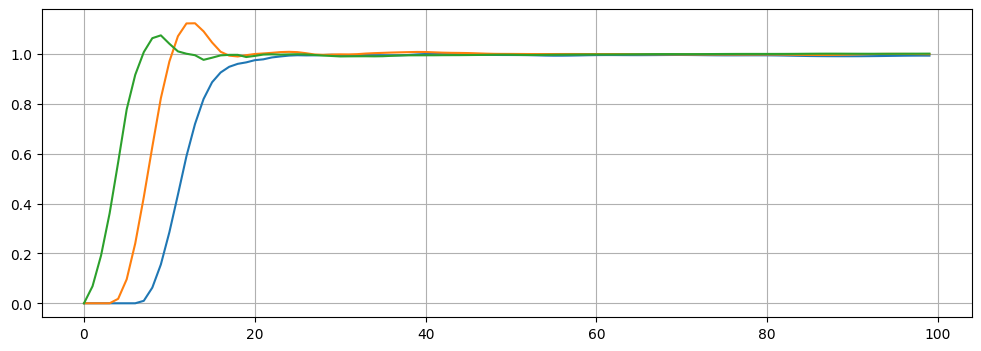

In [26]:
figure = plt.figure(figsize=(12, 4), dpi=100)
plt.plot(y[:, 1, :])
# plt.plot(du[:, 0, :])
plt.grid()